<a href="https://colab.research.google.com/github/noahruiz416/UFC-Fight-Prediction-Application-Model/blob/main/Notebooks/catBoostFeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From the results of the past notebook we will continue our feature selection process for our catboost model 
In particular this notebook will try the following attempts to narrow down features for selection: 
  1. Keeping All Categorical Features, except referee & location. With the goal of selecting 5 key features
  2. Removing all Categorical Features. With the goal of selecting 5 key features

  

## Installing Dependencies

-- If you are using the google collab environment you will need to pip install catboost and shapley libraries, which we have included in this notebook

-- In addition see: https://github.com/noahruiz416/UFC-Fight-Prediction-Application-Model/tree/main/Data, for needed data loads
  
  -- For this project you will need the processed train and test files

In [91]:
#installing shap and catboost, only need to run once, if you have not comment out the #
#!pip install shap
#!pip install catboost 

In [92]:
#ML Libraries
from catboost import CatBoostClassifier

#Preprocessing 
from sklearn import preprocessing

#Essential for Data Loading 
import pandas as pd 

#Shapley for feature importance 
import shap

#metrics 
from sklearn.metrics import classification_report

## Prepping our training Data for Model 1 and Model 2
-- We prep our train data seperate from test data to prevent possible target leakage

In [93]:
#for now we will load the same files, however we create two distinct vars for manipulations pertaining to our overall plan

model1_x_train = pd.read_csv('X_processed_train.csv', index_col = 0)
model1_y_train = pd.read_csv('y_processed_train.csv', index_col = 0)

model2_x_train = pd.read_csv('X_processed_train.csv', index_col = 0)
model2_y_train = pd.read_csv('y_processed_train.csv', index_col = 0)

#binarizing the y train labels from red, blue -> red = 1, blue = 0
model1_y_train = preprocessing.LabelBinarizer().fit_transform(model1_y_train['Winner'])
model2_y_train = preprocessing.LabelBinarizer().fit_transform(model2_y_train['Winner'])


## Model 1 Training

Assumption: Keep All Categorical Features, except referee & location. With the goal of selecting 5 key features. We get rid of those two features since we will not know either going into a fight. 

In [94]:
#because of our assumption we must create different cat columns for each model 
#further we will take out 'referee' and 'location' for this model 
 
model1_cat_cols = ["R_fighter", "B_fighter", "weight_class", "B_Stance", "R_Stance"]
model1_x_train.drop(columns = ["Referee", "location"], inplace = True)

#With the data processed we can now train our model with the specified cat cols 
model1 = CatBoostClassifier(cat_features = model1_cat_cols)

#model1.fit(model1_x_train, model1_y_train, verbose=False)
model1.select_features(X= model1_x_train, 
                      y = model1_y_train,
                      features_for_select = model1_x_train.columns,
                      num_features_to_select = 5, 
                      logging_level = 'Silent')

{'eliminated_features': [60,
 'selected_features': [0, 1, 69, 126, 139],
 'selected_features_names': ['R_fighter',
  'B_fighter',
  'B_Reach_cms',
  'R_losses',
  'R_age']}

## Model 2 Training

Assumption: Removing all Categorical Features. With the goal of selecting 5 key features


In [95]:
#because of our assumption we remove all categorical features from the model 
 
model2_cat_cols = ["Referee", "location", "R_fighter", "B_fighter", "weight_class", "B_Stance", "R_Stance"]
model2_x_train.drop(columns = model2_cat_cols, inplace = True)

#With the data processed we can now train our model with the specified cat cols 
model2 = CatBoostClassifier()

model2.select_features(X = model2_x_train, 
                      y = model2_y_train,
                      features_for_select = model2_x_train.columns,
                      num_features_to_select = 5,
                      logging_level = 'Silent')

{'eliminated_features': [57,
 'selected_features': [65, 70, 131, 133, 134],
 'selected_features_names': ['B_Reach_cms',
  'R_avg_opp_SIG_STR_pct',
  'R_Reach_cms',
  'B_age',
  'R_age']}

## Prepping our Test Data for Model 1 and Model 2

In [96]:
#for now we will load the same files, however we create two distinct vars for manipulations pertaining to our overall plan

model1_x_test = pd.read_csv('X_processed_test.csv', index_col = 0)
model1_y_test = pd.read_csv('y_processed_test.csv', index_col = 0)

model2_x_test = pd.read_csv('X_processed_test.csv', index_col = 0)
model2_y_test = pd.read_csv('y_processed_test.csv', index_col = 0)

#binarizing the y test labels from red, blue -> red = 1, blue = 0
model1_y_test = preprocessing.LabelBinarizer().fit_transform(model1_y_test['Winner'])
model2_y_test = preprocessing.LabelBinarizer().fit_transform(model2_y_test['Winner'])

#prepping test data columns 
model1_x_test.drop(columns = ["Referee", "location"], inplace = True)
model2_x_test.drop(columns = model2_cat_cols, inplace = True)

## Evaluating our models after prepping test data


In [97]:
y_true_model1 = model1_y_test
y_true_model2 = model2_y_test

y_pred_model1 = model1.predict(model1_x_test)
y_pred_model2 = model2.predict(model2_x_test)

target_names = ['Blue Winner', 'Red Winner']


In [98]:
#report for model 1
print(classification_report(y_true_model1, y_pred_model1, target_names = target_names))


              precision    recall  f1-score   support

 Blue Winner       0.56      0.55      0.55       430
  Red Winner       0.76      0.77      0.77       818

    accuracy                           0.69      1248
   macro avg       0.66      0.66      0.66      1248
weighted avg       0.69      0.69      0.69      1248



In [99]:
#report for model 2
print(classification_report(y_true_model2, y_pred_model2, target_names = target_names))


              precision    recall  f1-score   support

 Blue Winner       0.50      0.26      0.34       430
  Red Winner       0.69      0.86      0.77       818

    accuracy                           0.65      1248
   macro avg       0.59      0.56      0.55      1248
weighted avg       0.62      0.65      0.62      1248



## With our Models Trained we can now get a summary of feature importance with the Shapley Values

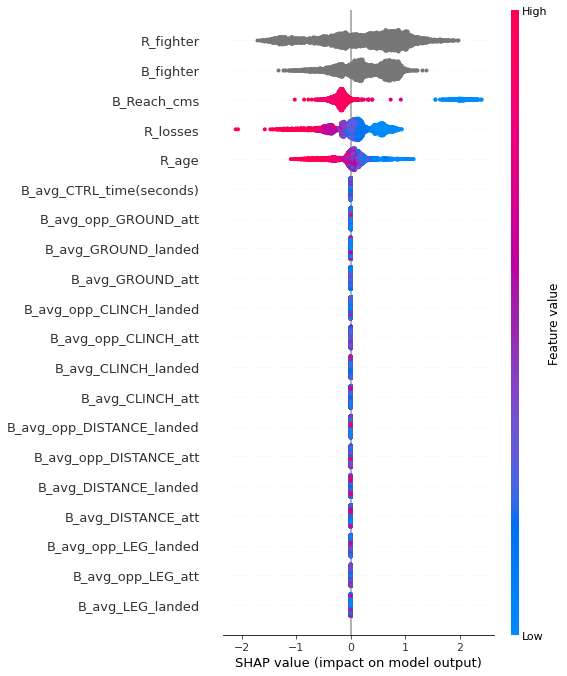

In [100]:
#shap summary for model 1
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(model1_x_train)
shap.summary_plot(shap_values1, model1_x_train)

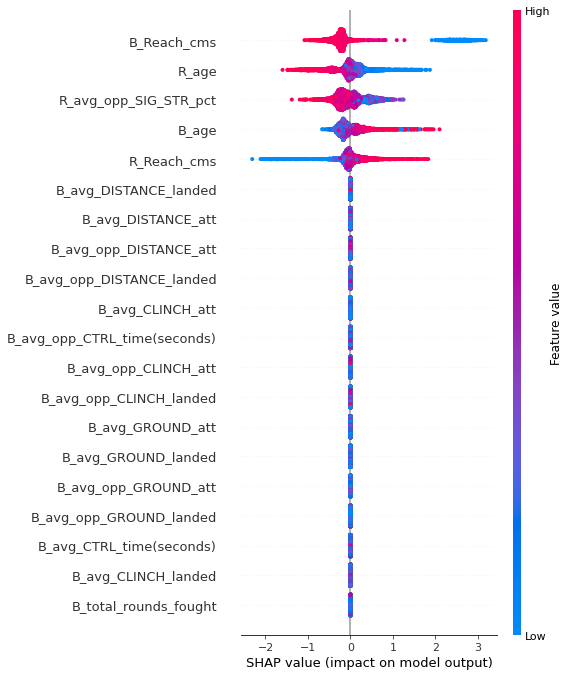

In [101]:
#shap summary for model 2
explainer2 = shap.TreeExplainer(model2)
shap_values2= explainer2.shap_values(model2_x_train)
shap.summary_plot(shap_values2, model2_x_train)

## Based on Models and Shap output it is clear that there are some key variables that lead to a strong model. In particular these variables all come up often: 

Because of this we will iterate a third model using only these features. In addition when pertaining to fighting, these features make sense in the context of MMA.

- B_Reach_cms
- R_Reach_cms
- B_age
- R_age
- B_fighter
- R_fighter
- R_Losses 
- B_Losses

## Model 3 Train Data Prep

In [102]:
#loading in data
model3_x_train = pd.read_csv("X_processed_train.csv", index_col = 0)
model3_y_train = pd.read_csv("y_processed_train.csv", index_col = 0)

model3_y_train = preprocessing.LabelBinarizer().fit_transform(model3_y_train['Winner'])

#selecting subset of features for model 3 
model3_x_train = model3_x_train[['B_Reach_cms', 'R_Reach_cms', 'B_age', 'R_age',
                                'B_fighter', 'R_fighter', 'R_losses', 'B_losses']]

## Model 3 Training

In [103]:
cat_vars_model3 = ['B_fighter', 'R_fighter']
model3 = CatBoostClassifier(cat_features = cat_vars_model3)

model3.fit(model3_x_train, model3_y_train, verbose = False)

## Model 3 Test Data Prep

In [104]:
#loading in data
model3_x_test = pd.read_csv("X_processed_test.csv", index_col = 0)
model3_y_test = pd.read_csv("y_processed_test.csv", index_col = 0)

model3_y_test = preprocessing.LabelBinarizer().fit_transform(model3_y_test['Winner'])

#selecting subset of features for model 3 
model3_x_test = model3_x_test[['B_Reach_cms', 'R_Reach_cms', 'B_age', 'R_age',
                                'B_fighter', 'R_fighter', 'R_losses', 'B_losses']]

## Model 3 Evaluation 

In [105]:
y_true_model3 = model3_y_test
y_pred_model3 = model3.predict(model3_x_test)

In [106]:
print(classification_report(y_true_model3, y_pred_model3, target_names = target_names))

              precision    recall  f1-score   support

 Blue Winner       0.63      0.40      0.49       430
  Red Winner       0.74      0.87      0.80       818

    accuracy                           0.71      1248
   macro avg       0.68      0.64      0.64      1248
weighted avg       0.70      0.71      0.69      1248



## Model 3 Shap Plots

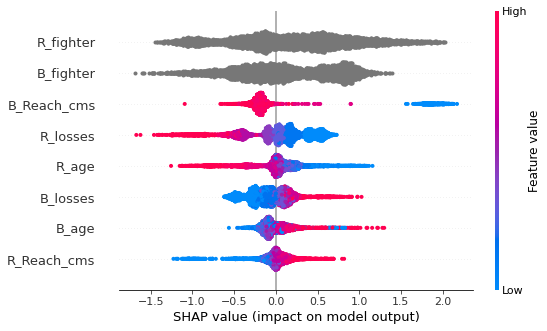

In [107]:
#shap summary for model 3
explainer3 = shap.TreeExplainer(model3)
shap_value3= explainer3.shap_values(model3_x_train)
shap.summary_plot(shap_value3, model3_x_train)